In [1]:
import json
import pandas as pd
import re
import dateparser
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pymorphy2
from sklearn.manifold import TSNE
import umap
import matplotlib.cm as cm
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD, NMF, SparsePCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer

morph = pymorphy2.MorphAnalyzer(lang='ru')

from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

from tqdm import tqdm
tqdm.pandas()

In [38]:
data = json.load(open("resule_parsing_new.json", "r", encoding="utf-8"))
df = pd.DataFrame(data)
origin_df = df.copy()

In [7]:
df["description"] = df["description"].map(lambda x: re.sub('[0-9:,\.!?]', '', x))
df["description"] = df["description"].progress_map(lambda x: " ".join([morph.parse(word)[0].normal_form for word in x.split() if word not in russian_stopwords]))

100%|██████████| 15459/15459 [03:53<00:00, 66.21it/s]


In [18]:
with open("decription.pkl", "wb") as f:
    pickle.dump(df["description"], f)

In [39]:
df["description"] = pickle.load(open("decription.pkl", "rb"))

In [40]:
data[0]["text_params"]

['Дополнительная информация Декоративные элементы высокая резинка Особенности модели хлопок Страна производства Россия Модель спортивная носки высокие спортивные Пол Женский',
 'Дополнительная информация Декоративные элементы высокая резинка Особенности модели хлопок Страна производства Россия Модель спортивная носки высокие спортивные Пол Женский Сезон демисезон',
 'Габариты Длина упаковки 4 см Высота упаковки 25 см Ширина упаковки 8 см']

In [41]:
tfidf = pickle.load(open("models/tdidf.pickle", "rb"))
lda = pickle.load(open("models/lda.pickle", "rb"))

C:\Users\Никита\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Никита\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Никита\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LatentDirichletAllocation f

In [42]:
class TopicModeler(object):
    def __init__(self, tfidf, lda):
        self.lda = lda
        self.tfidf = tfidf

    def __call__(self, text):
        vectorized = self.tfidf.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    
    def get_keywords(self, text, n_topics=3, n_keywords=5):
        lda_topics = np.squeeze(self(text), axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]

        top_topics_words_dists = [self.lda.components_[i] for i in n_topics_indices]

        shape= (n_keywords * n_topics, self.lda.components_.shape[1])
        keywords = np.zeros(shape=shape)
        for i, topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k, j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
                
        keywords = [keyword[0] for keyword in self.count_vect.inverse_transform(keywords)]
        return keywords
    
    
topic = TopicModeler(tfidf, lda)

In [43]:
df.head()

,name,url,price,old_price,order_count,celler_sold,celler_rating,name_comp,celler_mean_delivery_time,celler_percent_bad_products,celler_working_time,celler_link,img_link,description,text_params,comments_link,search_category
0,Носки высокие набор,https://www.wildberries.ru/catalog/55139609/de...,394,2193,14000.0,180284.0,4.8,RIFTEX,99.6%,0.1%,2 года и 4 мес,https://www.wildberries.ru/seller/189865,https://basket-04.wb.ru/vol551/part55139/55139...,трендовый высокий красивый носка девушка женщи...,[Дополнительная информация Декоративные элемен...,https://www.wildberries.ru/catalog/55139609/fe...,носки
1,Шторы портьеры Бархат для спальни гостиной 250...,https://www.wildberries.ru/catalog/88868650/de...,5248,14580,1600.0,232888.0,4.6,ПАРАСКЕВА,None,0.3%,5 лет и 7 мес,https://www.wildberries.ru/seller/25234,https://basket-05.wb.ru/vol888/part88868/88868...,бархатный готовый штора портьера елизавета три...,[Дополнительная информация Тип крепления штор ...,https://www.wildberries.ru/catalog/88868650/fe...,шторы
2,Кеды текстильные,https://www.wildberries.ru/catalog/7741188/det...,1036,1920,59600.0,1073051.0,4.6,MakFine,None,0.4%,7 лет и 4 мес,https://www.wildberries.ru/seller/12173,https://basket-01.wb.ru/vol77/part7741/7741188...,лёгкий практичный женский кед плоский подошва ...,[Дополнительная информация Материал стельки на...,https://www.wildberries.ru/catalog/7741188/fee...,кросовки
3,Лампа накаливания для духовок (+300°) E14 15Вт...,https://www.wildberries.ru/catalog/154480245/d...,228,None,200.0,20816.0,4.3,Premium Express On-Line,97.7%,0.2%,3 года и 1 мес,https://www.wildberries.ru/seller/64509,https://basket-10.wb.ru/vol1544/part154480/154...,лампа накаливание освещение духовка изготовить...,[Технические особенности Напряжение 220 В Мощн...,https://www.wildberries.ru/catalog/154480245/f...,лампочки
4,Набор свечи из вощины воска натуральные аромат...,https://www.wildberries.ru/catalog/17163883/de...,316,720,26000.0,74753.0,4.7,Баскаков Алексей Юрьевич,100%,0%,2 года и 8 мес,https://www.wildberries.ru/seller/108647,https://basket-02.wb.ru/vol171/part17163/17163...,набор свеча вощин изготовить натуральный пчели...,[Дополнительная информация Вес товара с упаков...,https://www.wildberries.ru/catalog/17163883/fe...,свечи


In [44]:
for text_feature in range(4):
    for i in range(len(data)):
        if text_feature < len(df.loc[i, "text_params"]):
            df.loc[i, f"meta_text_{text_feature}"] = df.loc[i, "text_params"][text_feature]

df["price"] = df["price"].astype("float")
df["old_price"] = df["old_price"].astype("float")
df["celler_mean_delivery_time"] = df["celler_mean_delivery_time"].apply(lambda x: float(x[:x.index("%")]) if x is not None else 99.3)
df["celler_percent_bad_products"] = df["celler_percent_bad_products"].apply(lambda x: float(x[:x.index("%")]) if x is not None else 99.3)

def string_to_date(text):
    """переводим строку с тем сколько работал в число месяцев"""
    if text is None:
        return None
    if text == "Новый магазин":
        return 0
    years, months = 0, 0
    words = text.split()
    if len(words) == 5:
        years = words[0]
        months = words[3]
    elif len(words) == 2:
        if words[1] in ["лет", "года"]:
            years = words[0]
        else:
            months = words[0]
    return int(years) * 12 + int(months)

df["sale_percent"] = (df["price"] / df["old_price"]).fillna(0)
df["percent_order_of_all_seller"] = (df["order_count"] / df["celler_sold"]).fillna(0.03029)
df["not_info_old_price"] = df["old_price"].isna()
df["not_info_order_count"] = df["order_count"].isna()
df["celler_working_time_norm"] = df["celler_working_time"].apply(string_to_date)

In [45]:
# сделать потом классификатор search category и юзать!

df.drop(["celler_sold", "comments_link", "meta_text_0", 
         "meta_text_1", "meta_text_2", "meta_text_3", "celler_working_time",
         "name_comp", "celler_link", "img_link", "text_params", "search_category", "name"], axis=1, inplace=True)

for feature in ["celler_working_time_norm", "old_price", "order_count", "price", "celler_rating"]:
    df[feature] = df[feature].fillna(df[feature].mean())

In [46]:
df.to_csv("original_data.csv")

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
descr = tfidf.fit_transform(df["description"])
text_embeddings = lda.transform(descr)

In [26]:
urls = df["url"]
df.drop(["url", "description"], axis=1, inplace=True)

In [27]:
normalizer = Normalizer().fit(df.values)
pickle.dump(normalizer, open("models/normalizer.pickle", "wb"))

df = pd.DataFrame(data=normalizer.transform(df), columns=df.columns)
df = df.join(pd.DataFrame(data=text_embeddings*10, columns=[f"embed_{i}" for i in range(text_embeddings.shape[1])]))

C:\Users\Никита\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but Normalizer was fitted without feature names
  warnings.warn(


In [28]:
CLUST_N = 40

kmeans = KMeans(n_clusters=CLUST_N)
clust_labels = kmeans.fit_predict(df)
clust_centers = kmeans.cluster_centers_

C:\Users\Никита\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
umap_clustering = umap.UMAP(n_components=2, min_dist=0.2)
umap_embeddings = umap_clustering.fit_transform(df.values)

C:\Users\Никита\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited at iteration 14 with accuracies 
[1.85038910e-12 5.18980976e-06 1.00891500e-05 5.53938373e-06]
not reaching the requested tolerance 7.2099930651839046e-06.
  _, diffusion_map = lobpcg(


In [30]:
clusters = {clust_ind : [] for clust_ind in range(CLUST_N)}

for emb, label in zip(umap_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])

In [31]:
colors = cm.rainbow(np.linspace(0, 1, CLUST_N))

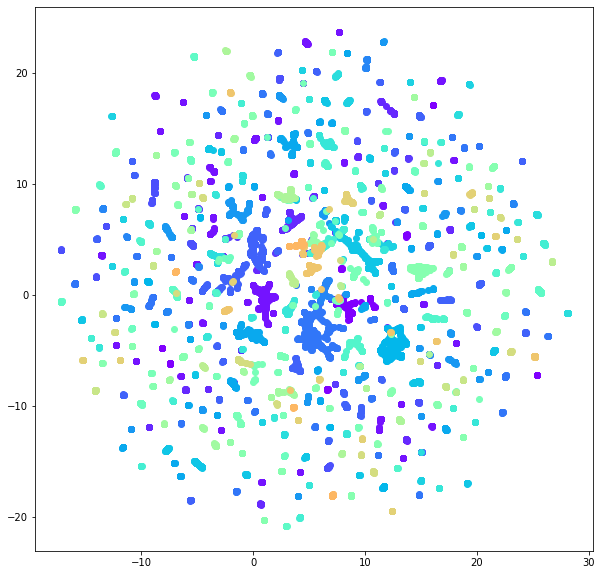

In [32]:
plt.figure(figsize=(10,10))
for ind, color in zip(range(30), colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
plt.show()

In [33]:
clusters_domain = pd.DataFrame(data=umap_embeddings, columns=["embed_1", "embed_2"])
clusters_domain["url"] = urls

In [34]:
clusters_domain.to_csv("clusters_domain.csv")
#origin_df.to_csv("original_data.csv")

In [35]:
pickle.dump(umap_clustering, open("models/umap_clustering.pickle", "wb"))

c:\users\никита\appdata\local\programs\python\python39\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [43]:
def preprocess_data(data):
    df = pd.DataFrame(data).iloc[0]
    df["description"] = re.sub('[0-9:,\.!?]', '', df["description"])
    df["description"] = " ".join([morph.parse(word)[0].normal_form for word in df["description"].split() if word not in russian_stopwords])
    
    df["price"] = float(df["price"])
    df["old_price"] = float(df["old_price"])
    df["celler_mean_delivery_time"] = float(df["celler_mean_delivery_time"][:df["celler_mean_delivery_time"].index("%")]) if df["celler_mean_delivery_time"] is not None else 99.3
    df["celler_percent_bad_products"] = float(df["celler_percent_bad_products"][:df["celler_percent_bad_products"].index("%")]) if df["celler_percent_bad_products"] is not None else 99.3
    df["sale_percent"] = (df["price"] / df["old_price"]) if df["price"] is not None else 0
    df["not_info_order_count"] = 1 if df["order_count"] is None else 0
    df["celler_sold"] = df["celler_sold"] if df["celler_sold"] is not None else 1
    
    df["percent_order_of_all_seller"] = (df["order_count"] / df["celler_sold"]) if df["order_count"] is not None else 0.03029
    df["not_info_old_price"] = 1 if df["old_price"] is None else 0
    df["celler_working_time_norm"] = string_to_date(df["celler_working_time"])
    
    df.drop(["celler_sold", "comments_link", "celler_working_time",
         "name_comp", "celler_link", "img_link", "text_params", "search_category"], inplace=True)

    for feature, mean in zip(["celler_working_time_norm", "old_price", "order_count", "price", "celler_rating"],
                             [0.014, 0.58, 0.5, 0.26, 0.002]):
        df[feature] = mean if df[feature] is None else df[feature]
    
    descr = tfidf.transform([df["description"]])
    text_embeddings = lda.transform(descr)
    
    urls = df["url"]
    df.drop(["url", "description"], inplace=True)
    
    columns = ['price', 'old_price', 'order_count', 'celler_rating', 'celler_mean_delivery_time', 
               'celler_percent_bad_products', 'sale_percent', 'percent_order_of_all_seller', 
               'not_info_old_price','not_info_order_count', 'celler_working_time_norm']
    df = pd.DataFrame(data=normalizer.transform(df.values.reshape((1, -1))), columns=columns)
    df = df.join(pd.DataFrame(data=text_embeddings*10, columns=[f"embed_{i}" for i in range(text_embeddings.shape[1])]))
    return df

In [37]:
tree = KDTree(df, leaf_size=2)
pickle.dump(tree, open("models/kd_tree.pickle", "wb"))

In [45]:
def k_nearest_items(df, k=100):
    nearest = tree.query(df, k=k)[1][0]
    
    nearest_samples = origin_df.iloc[nearest]
    return nearest_samples

In [64]:
def position_in_domain(df):
    embedding = umap_clustering.transform(df)
    return embedding[0]

In [68]:
position_in_domain(preprocess_data(data[0]))

array([[ 2.81995 , -8.860588]], dtype=float32)